In [1]:
from  graphviz import Source


### Постановка задачи
Построить простую модель энергопотребления здания по среднему значению, 
оценить эффективность модели через метрику
\begin{equation}
RMSLE = {\sqrt{\sum_{i=1}^{n}{(log(p_i+1) - log(a_i+1))^2} \over n}}.
\end{equation}
* n - число наблюдений
* log - натуральный логарифм
* p_i - вычисленное значение метрики
* a_i - заданное значение метрики

Данные: http://video.ittensive.com/machine-learning/ashrae/train.0.0.csv.gz
Соревнование: https://www.kaggle.com/c/ashrae-energy-prediction/

© ITtensive, 2020

### Загрузка библиотек

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 8, 4
from scipy import interpolate

### Загрузка данных
Энергопотребление в здании 0

Дополнительно сразу отсечем пустые дни и выделим час из значения времени

In [3]:
energy_0 = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.0.csv.gz")
energy_0 = energy_0[energy_0["meter_reading"] > 0]
energy_0["timestamp"] = pd.to_datetime(energy_0["timestamp"])
energy_0["hour"] = energy_0["timestamp"].dt.hour
print (energy_0.head())

      building_id  meter           timestamp  meter_reading  hour
704             0      0 2016-01-30 08:00:00        43.6839     8
725             0      0 2016-01-31 05:00:00        37.5408     5
737             0      0 2016-01-31 17:00:00        52.5571    17
2366            0      0 2016-04-08 14:00:00        59.3827    14
2923            0      0 2016-05-01 19:00:00       448.0000    19


### Среднее потребление по часам

         Среднее  Медиана
hour                     
0     238.683751  240.261
1     239.211608  240.944
2     239.651475  242.309
3     240.203588  244.357
4     239.263176  245.039


<AxesSubplot:xlabel='hour'>

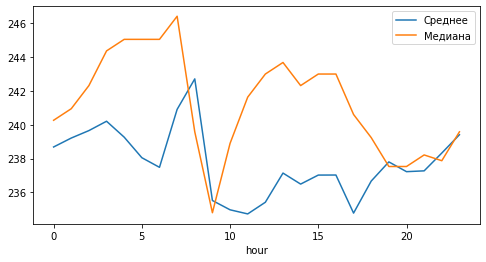

In [4]:
energy_0_hours = energy_0.groupby("hour")
energy_0_averages = pd.DataFrame(
    {"Среднее": energy_0_hours.mean()["meter_reading"],
     "Медиана": energy_0_hours.median()["meter_reading"]})
print (energy_0_averages.head())
energy_0_averages.plot()

### Интерполяция

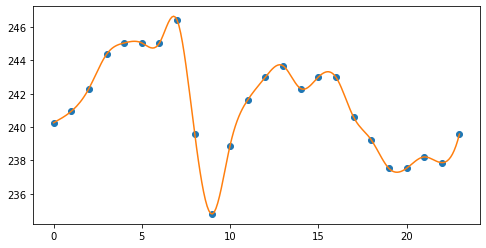

In [5]:
x= np.arange(0,24)
y =interpolate.interp1d(x, energy_0_hours.median()["meter_reading"], kind='cubic' )
xn= np.arange(0,23.1, 0.1)
yn=y(xn)
plt.plot (x, energy_0_hours.median()["meter_reading"], 'o', xn, yn, '-' )

### Разделение данных на обучение и проверку
Выделим 20% всех данных на проверку, остальные оставим на обучение

In [6]:
energy_0_train, energy_0_test = train_test_split(energy_0, test_size=0.2)
energy_0_train.head()

,building_id,meter,timestamp,meter_reading,hour
5951,0,0,2016-09-04 23:00:00,237.531,23
5038,0,0,2016-07-28 22:00:00,296.914,22
4927,0,0,2016-07-24 07:00:00,247.087,7
5834,0,0,2016-08-31 02:00:00,247.087,2
3901,0,0,2016-06-11 13:00:00,244.357,13


### Создадим модели
Среднее и медианное значение потребление энергии по часам

In [7]:
energy_0_train_hours = energy_0_train.groupby("hour")
energy_0_train_averages = pd.DataFrame(
    {"Среднее": energy_0_train_hours.mean()["meter_reading"],
     "Медиана": energy_0_train_hours.median()["meter_reading"]})
energy_0_train_averages

,Среднее,Медиана
hour,,
0,238.365222,240.9440
1,237.080946,240.2610
2,240.269132,242.3090
3,238.828608,244.3570
4,235.952082,243.6740
5,239.843452,245.7220
6,238.986134,246.4040
7,241.010498,247.0870
8,243.599374,238.8960


### Функция проверки модели
\begin{equation}
RMSLE = {\sqrt{\sum_{i=1}^{n}{(log(p_i+1) - log(a_i+1))^2} \over n}}.
\end{equation}

Для вычисления метрики создадим шесть новых столбцов в тестовом наборе данных: с логарифмом значения метрики, предсказанием по среднему и по медиане, а также с квадратом разницы предсказаний и логарифма значения. Последний столбец добавим, чтобы сравнить предсказание с его отсутствием - нулями в значениях.

In [8]:
def calculate_model (x):
    meter_reading_log = np.log(x.meter_reading + 1)
    meter_reading_mean = np.log(energy_0_train_averages["Среднее"][x.hour] + 1)
    meter_reading_median = np.log(energy_0_train_averages["Медиана"][x.hour] + 1)
    x["meter_reading_mean_q"] = (meter_reading_log - meter_reading_mean)**2
    x["meter_reading_median_q"] = (meter_reading_log - meter_reading_median)**2
    x["meter_reading_zero_q"] = (meter_reading_log)**2
    return x

energy_0_test = energy_0_test.apply(calculate_model,
                                    axis=1, result_type="expand")
print (energy_0_test.head())
energy_0_test.head()

      building_id  meter           timestamp  meter_reading  hour  \
8150            0      0 2016-12-05 14:00:00        187.022    14   
8164            0      0 2016-12-06 04:00:00        182.244     4   
4481            0      0 2016-07-05 17:00:00        187.022    17   
5966            0      0 2016-09-05 14:00:00        236.166    14   
6224            0      0 2016-09-16 08:00:00        240.944     8   

      meter_reading_mean_q  meter_reading_median_q  meter_reading_zero_q  
8150              0.051362                0.066447             27.421550  
8164              0.066069                0.083584             27.152630  
4481              0.048218                0.060757             27.421550  
5966              0.000031                0.000654             29.907339  
6224              0.000119                0.000072             30.125897  


,building_id,meter,timestamp,meter_reading,hour,meter_reading_mean_q,meter_reading_median_q,meter_reading_zero_q
8150,0,0,2016-12-05 14:00:00,187.022,14,0.051362,0.066447,27.421550
8164,0,0,2016-12-06 04:00:00,182.244,4,0.066069,0.083584,27.152630
4481,0,0,2016-07-05 17:00:00,187.022,17,0.048218,0.060757,27.421550
5966,0,0,2016-09-05 14:00:00,236.166,14,0.000031,0.000654,29.907339
6224,0,0,2016-09-16 08:00:00,240.944,8,0.000119,0.000072,30.125897


Теперь остается просуммировать квадраты расхождений, разделить на количество значений и извлечь квадратный корень

In [9]:
energy_0_test_median_rmsle = np.sqrt(energy_0_test["meter_reading_median_q"].sum() / len(energy_0_test))
energy_0_test_mean_rmsle = np.sqrt(energy_0_test["meter_reading_mean_q"].sum() / len(energy_0_test))
energy_0_test_zero_rmsle = np.sqrt(energy_0_test["meter_reading_zero_q"].sum() / len(energy_0_test))
print ("Качество медианы:", energy_0_test_median_rmsle)
print ("Качество среднего:", energy_0_test_mean_rmsle)
print ("Качество нуля:", energy_0_test_zero_rmsle)

Качество медианы: 0.2605376006827737
Качество среднего: 0.2593398721638175
Качество нуля: 5.452448887119664
